<a href="https://colab.research.google.com/github/tylerschwartz1995/Sentiment-Classification-using-Pytorch/blob/main/Sentiment_Classification_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment 2: Best Model**

To find the best model, multiple models we're tried. I first tried by using Glove word embeddings with a LSTM. This model capped out at around 84% after trying different hyper-parameter combinations. I then tried the same thing but with a CNN. This model performed actually better with an accuracy around 85%. Next, to improve my performance, I researched into pre-trained models on hugging face (https://huggingface.co/). I first tried the 'bert_base' which achieved good scores of close to 86%. I tried different sequence lengths and achieved the optimal performance at a length 330 tokens, and a batch size of 32. I tried 'bert-large' as well but the size of the model was too big for my environment in colab. 

For my best model, I looked in word embeddings that were pre-trained on academic writing. I found two, Scibert and Spectre. I tried both with the same word length and batch size as illustrated above (others were tried but this ended up having the highest performance as well). Scibert performed slightly better as I achieved a accuracy of just abover 87% vs. 86.6% for Spectre. This was thus my final model as I was not able to find any better model after further exploring different hyperparameter combinations (learning rate, epochs, opimizers, etc...).

My code below was inspired based on a tutorial I did at https://mccormickml.com/2019/07/22/BERT-fine-tuning/ which helped me learn how to use pre-trainers such as Bert amongst others from hugging face. 

**Step 1:** Installing and Loading Packages

In [ ]:
#Installing 'transformers' module
!pip install transformers

In [ ]:
import pandas as pd

#For Plots
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

**Step 2:** Mounting Drive to Access Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Step 3:** Checking Availability of GPU

In [ ]:
#Importing torch
import torch

#Checking if GPU available in Colab
#If available telling torch to use GPU ()
#If not, colab will use cpu
if torch.cuda.is_available():        
    device = torch.device("cuda") #Telling torch to use GPU if available
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu") #Use CPU if GPU not available

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


**Step 4:** Loading Data and Manipulations

In [ ]:
#Importing Datasets
train = pd.read_csv('/content/drive/My Drive/HW2 Data/train.csv')
test = pd.read_csv('/content/drive/My Drive/HW2 Data/test.csv')
text = pd.read_csv('/content/drive/My Drive/HW2 Data/text.csv')
node_id = pd.read_csv('/content/drive/My Drive/HW2 Data/nodeid2paperid.csv')

In [ ]:
#Merging Text with Node_ID
text = text.merge(node_id, how = "left",left_on='paper id', right_on='paper id')

#Merge Train with Text (Left Merge)
train = train.merge(text, how = "left",left_on='node idx', right_on='node idx')

#Merge Test with Text (Left Merge)
test = test.merge(text, how = "left",left_on='node idx', right_on='node idx')

In [ ]:
#Combining title with text as this was shown to have better performance as I was able to capture information in model from title
train['text'] = train['title'] + train['abstract']
test['text'] = test['title'] + test['abstract']

#Dropping uneeded columns
train.drop(columns=['node idx','paper id','title','abstract'], inplace=True)

**Step 5:** Data Exploration and Added Manipulations

In [ ]:
#Printing Shape of Training and Test Sets
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

Train shape :  (60000, 2)
Test shape :  (13718, 5)


In [ ]:
#Printing head of training set
print(train.head())

   label                                               text
0      4  evasion attacks against machine learning at te...
1      5  how hard is computing parity with noisy commun...
2      8  a promise theory perspective on data networksN...
3      6  webvrgis based city bigdata 3d visualization a...
4      4  information theoretic authentication and secre...


In [ ]:
#Checking for Missing Values
null_train = train.isnull().sum() * 100 / len(train)
null_test = test.isnull().sum() * 100/ len(test)
pd.concat([null_train, null_test], axis=1).rename(columns={0:'train missing %', 1:'test missing %'}).head() 
#No missing values in dataset

,train missing %,test missing %
label,0.0,NaN
text,0.0,0.0
node idx,NaN,0.0
paper id,NaN,0.0
title,NaN,0.0


Exploring Distribution of Target Variable

In [ ]:
#Counting how often each label appears in training set
target_count = train[['label','text']].groupby('label').aggregate({'text':'count'}).reset_index().sort_values('text',ascending=False)

import plotly.express as px
#Plotting Distribution
px.bar(target_count[target_count['text']>1],x='label',y='text')

#Label 16 has a much higher representation than other labels

Distribution of Words

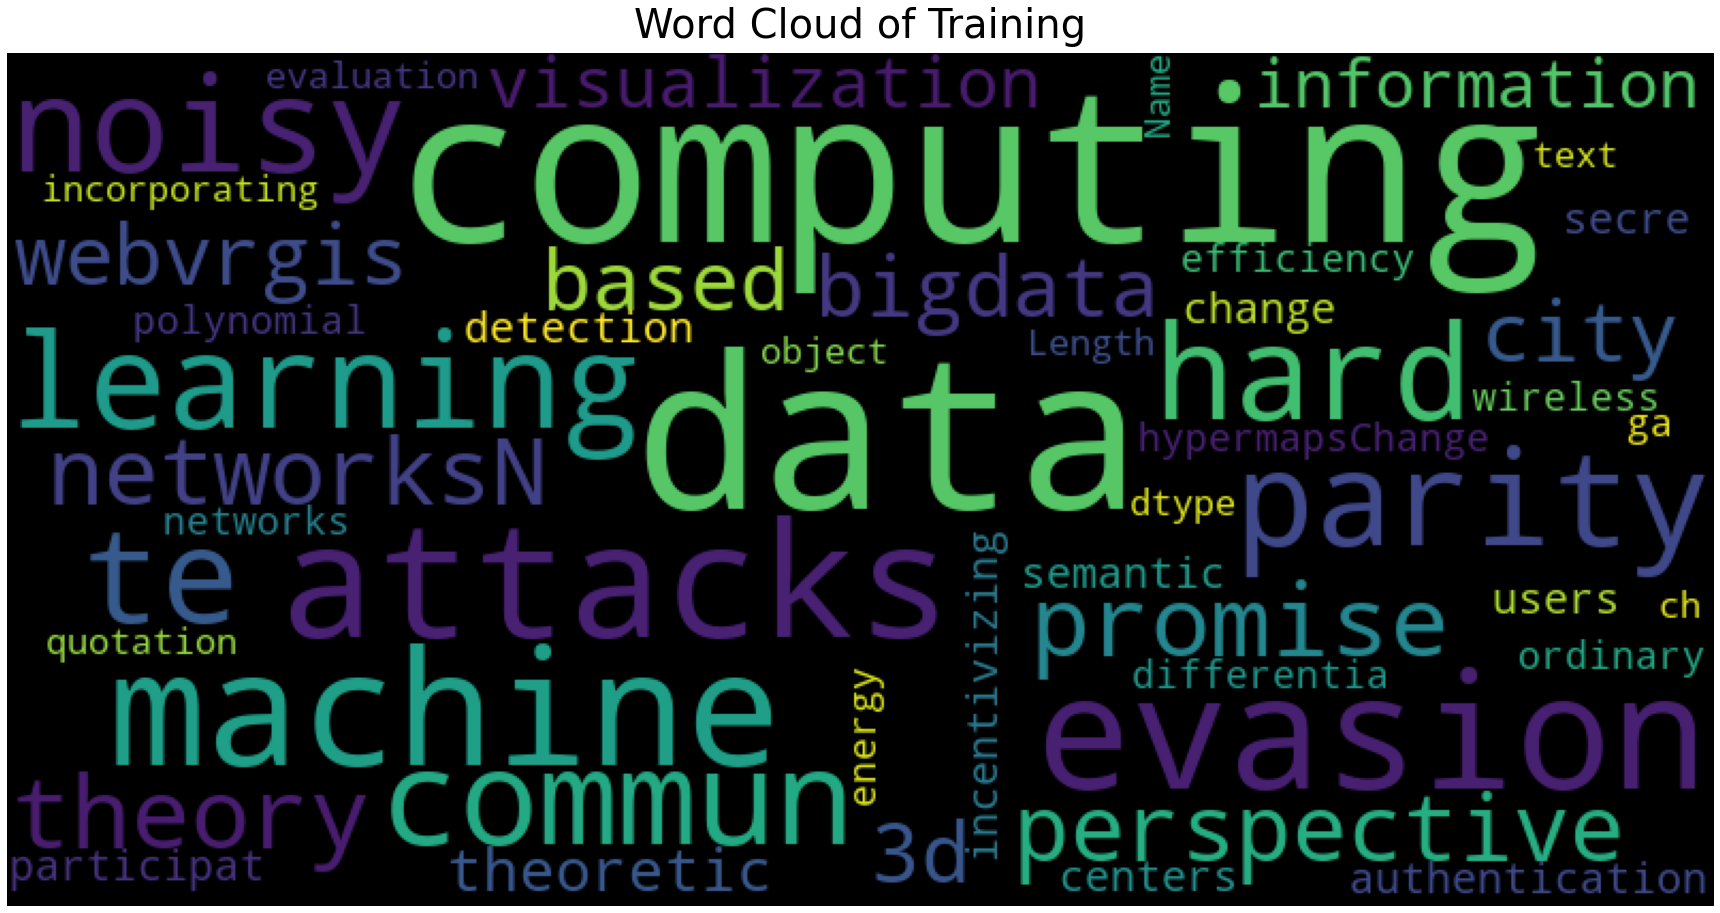

In [ ]:
#Producing word cloud of words in training set
from wordcloud import WordCloud, STOPWORDS
#Defining 'plot_wordcloud' which prinints a max of 200 most freqeunt words in text with no stopwords
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

#Calling function to produce plot
plot_wordcloud(train["text"], title="Word Cloud of Training")

#Most common words appear to be computer science related: computig, data, machines. etc..

**Step 6:** Pre-Processing Data (Tokenization)

In [ ]:
#Storing text (abstracts) and Labels from Training into two seperate objects
text = train.text.values
labels = train.label.values

Tokenizing words (uncased) using scibert from hugging face

In [ ]:
from transformers import *

#Loading scitbert Tokenizer
#Chose scibert as text is academic writing and so embeddings from scibert were trained on academic writing
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased',do_lower_case=True)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



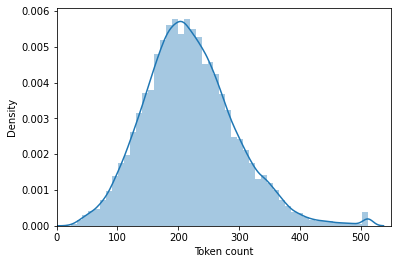

In [ ]:
#Plotting Distribution of Length of Tokens for Training Set Observations
#Will help in deciding appropriate length to set

#Finding token lengths
token_lens = []
for txt in text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

#Producing Plot
sns.distplot(token_lens)
plt.xlim([0, 550]);
plt.xlabel('Token count');

#Can see that peak number of words per observation is around 200
#Can see how much length can be fit in model but if needed between 300-380 seems safe

Tokenizing Sample Observation to See Sample Output

In [ ]:
#Original Abstract
print(' Original: ', text[0])

#Abstract split into tokens
print('Tokenized: ', tokenizer.tokenize(text[0]))

#Abstract mapped to token IDs
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[0])))

#Everything looks good

 Original:  evasion attacks against machine learning at test timeIn security-sensitive applications, the success of machine learning depends on a thorough vetting of their resistance to adversarial data. In one pertinent, well-motivated attack scenario, an adversary may attempt to evade a deployed system at test time by carefully manipulating attack samples. In this work, we present a simple but effective gradient-based approach that can be exploited to systematically assess the security of several, widely-used classification algorithms against evasion attacks. Following a recently proposed framework for security evaluation, we simulate attack scenarios that exhibit different risk levels for the classifier by increasing the attacker's knowledge of the system and her ability to manipulate attack samples. This gives the classifier designer a better picture of the classifier performance under evasion attacks, and allows him to perform a more informed model selection (or parameter setting)

Tokenizing Texts Using Loaded SciBert Tokenizer

In [ ]:
#Creating empty objects for input ids and attention masks
input_ids = []
attention_masks = []

#For loop for every abstract to tokenize each observation
for sequence in text:
    #Encode_plus is tokenizing the sequence, padding the sequence to max length,
    #Adding special token for beginning and end of sequence (CLS and SEP),
    #And constructing Attention masks
    encoded_dict = tokenizer.encode_plus(
                        sequence,  #Fed sequence into loop  
                        add_special_tokens = True, #Creating tokens for beginning and end (CLS and SEP)
                        max_length = 330,  #330 chosen based on plot and trade-off between batch size (achived best performance)
                        pad_to_max_length = True, #Padding sequence to max length
                        return_attention_mask = True, #Creating attention masks
                        return_tensors = 'pt', 
                   )
    
    #Appending encoded sequence to list   
    input_ids.append(encoded_dict['input_ids'])
    
    #Appending attention masks to list
    attention_masks.append(encoded_dict['attention_mask'])

#Converting Created Lists to Tensorys
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

#Converting Labels to Tensor
labels = torch.tensor(labels)

In [ ]:
#Printing Sample Output
print('Original: ', text[100])
print('Token IDs:', input_ids[100])

#Everything looks good

**Step 7:** Splitting Data into Training and Test Set

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Creating tensor dataset of input ids, attention masks, and labels
dataset = TensorDataset(input_ids, attention_masks, labels)

#90-10 Train Validation Split
train_size = int(0.9 * len(dataset)) #90% training vs 10% validation chosen 
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Printing size of each dataset
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

54,000 training samples
6,000 validation samples


**Step 8:** Modelling

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#Setting batch size
batch_size = 32  #32 chosen based on existing research and max length set

#Creating Data loaders for Training and Validation Sets
#Training
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), #Specify to select batches randomly
            batch_size = batch_size 
        )

#Validation
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), #Specifying here to pull batches sequentially
            batch_size = batch_size
        )

Loading Scibert pre-trained model

In [ ]:
#Loading necceary modules (AdamW will be used as learner later)
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

model = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', #Loading scibert pre-trained model
                                  num_labels = 20, #Number of labels in dataset
                                  output_attentions = False,
                                  output_hidden_states = False,
                                  )

#Telling model to use gpu when run
model.cuda()

In [ ]:
#List of Parameters
params = list(model.named_parameters())

print('The SCIBERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The SCIBERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (31090, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias            

**Step 9:** Training Model

Choosing Learner and Setting Learning Rate

In [ ]:
#Setting learner to AdamW (as recommended by hugging face)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, #Setting learning rate to 2e-5 as done in scibert paper and best based on exploration
                  eps = 1e-8 #Chosen based on exploration of different values
                )

In [ ]:
#Using Warm up as recommended by the BERT paper to stabilize learning when approaching the minima
from transformers import get_linear_schedule_with_warmup

#Setting epochs to 2 based on exploration as validation loss start to increase after this point
epochs = 2

#Calculating total steps to take
total_steps = len(train_dataloader) * epochs

#Creating learning rate scheduler 
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
#Function to calculate accuracy of model
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Recording time after each batch is run
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training Model

In [ ]:
import random
import numpy as np

#Setting Seed
seed_val = 485684632

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Storing Result Statistics
training_stats = []

#Tracking total training time
total_t0 = time.time()

#Keeping best validation loss
#best_val_loss = float("inf")
#best_model = None

#Training Model (Based on code from here: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128)
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #Measuring Time of each epoch
    t0 = time.time()

    #Resetting total loss at each epoch
    total_train_loss = 0

    #Sending model to train mode
    model.train()

    #Running for each batch
    for step, batch in enumerate(train_dataloader):

        #Displaying progress every 40 batches
        if step % 40 == 0 and not step == 0:
            #Calculating time it took to run through batch
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #Unpacking training batch and sending to gpu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Setting gradient = 0
        model.zero_grad()        

        #Performing Forward pass
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        #Accumulated training loss over all batches
        total_train_loss += loss.item()

        #Performing backwards pass and calculating gradienta
        loss.backward()

        #Clipping gradient to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #Updating parameter based on calculated gradient and taking step
        optimizer.step()
        #Update learning rate using scheduler defined above
        scheduler.step()

    #Calculate average training loss over all batches for epoch
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    #How long did epoch take?
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    #Measuring performance on validation set after training
    print("")
    print("Running Validation...")

    #Starting time
    t0 = time.time()

    #Put model in evaluation mode since we are measuring performance on validation set
    model.eval()

    #Creating performance metrics
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    #Running batches on validation
    for batch in validation_dataloader:
        
        ##Unpacking validation batch and sending to gpu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        #Calculating logit preidctions
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        
        #Storing loss and logits of batch
        loss = result.loss
        logits = result.logits
            
        #Storing validation loss of batch
        total_eval_loss += loss.item()

        #Moving logits and labels to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Calculating accuracy of batch
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    #Calculating final validation accuracy
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #Calculating final validation loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    #If validation loss is lower than previous best, keeping
    #if avg_val_loss < best_val_loss:
        #best_val_loss = avg_val_loss
        #best_model = model
    
    #Printing how long validation took
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    #Recording performance mesures from epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,688.    Elapsed: 0:00:23.
  Batch    80  of  1,688.    Elapsed: 0:00:47.
  Batch   120  of  1,688.    Elapsed: 0:01:10.
  Batch   160  of  1,688.    Elapsed: 0:01:33.
  Batch   200  of  1,688.    Elapsed: 0:01:57.
  Batch   240  of  1,688.    Elapsed: 0:02:20.
  Batch   280  of  1,688.    Elapsed: 0:02:43.
  Batch   320  of  1,688.    Elapsed: 0:03:06.
  Batch   360  of  1,688.    Elapsed: 0:03:30.
  Batch   400  of  1,688.    Elapsed: 0:03:53.
  Batch   440  of  1,688.    Elapsed: 0:04:16.
  Batch   480  of  1,688.    Elapsed: 0:04:40.
  Batch   520  of  1,688.    Elapsed: 0:05:03.
  Batch   560  of  1,688.    Elapsed: 0:05:26.
  Batch   600  of  1,688.    Elapsed: 0:05:50.
  Batch   640  of  1,688.    Elapsed: 0:06:13.
  Batch   680  of  1,688.    Elapsed: 0:06:36.
  Batch   720  of  1,688.    Elapsed: 0:07:00.
  Batch   760  of  1,688.    Elapsed: 0:07:23.
  Batch   800  of  1,688.    Elapsed: 0:07:46.
  Batch   840  of

**Step 9:** Results

In [ ]:
#Creating dataframe for results of model
model_results = pd.DataFrame(data=training_stats)
model_results = model_results.set_index('epoch')

#Diplaying table of model results
model_results

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.629611,0.463005,0.856051,0:16:24,0:00:35
2,0.368876,0.435954,0.862035,0:16:25,0:00:35


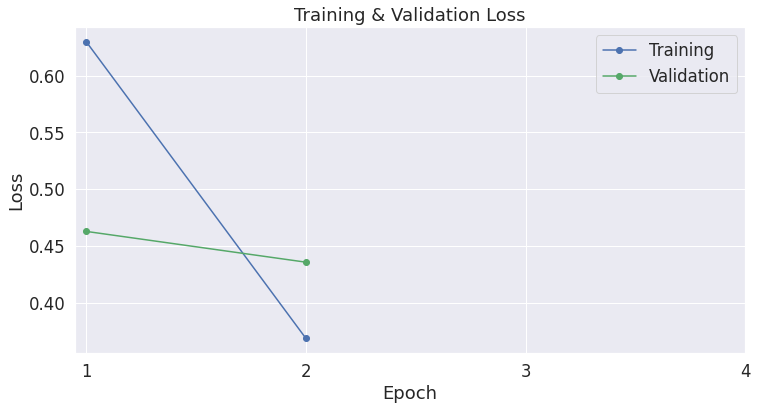

In [ ]:
#Plotting Training Loss and Validation Loss
#Options set
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

#Plotting
plt.plot(model_results['Training Loss'], 'b-o', label="Training")
plt.plot(model_results['Valid. Loss'], 'g-o', label="Validation")

#Labelling Plot
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Step 10: Prediction on Test Set

In [ ]:
#Using same code as before to tokenize test set abstracts

#Creaing object with text of abstracts for each observation
text = test.text.values

#Creating empty objects for input ids and attention masks
input_ids = []
attention_masks = []

#For loop for every abstract to tokenize each observation
for sequence in text:
    #Encode_plus is tokenizing the sequence, padding the sequence to max length,
    #Adding special token for beginning and end of sequence (CLS and SEP),
    #And constructing Attention masks
    encoded_dict = tokenizer.encode_plus(
                        sequence,  #Fed sequence into loop  
                        add_special_tokens = True, #Creating tokens for beginning and end (CLS and SEP)
                        max_length = 330,  
                        pad_to_max_length = True, #Padding sequence to max length
                        return_attention_mask = True, #Creating attention masks
                        return_tensors = 'pt', 
                   )
    
    #Appending encoded sequence to list   
    input_ids.append(encoded_dict['input_ids'])
    
    #Appending attention masks to list
    attention_masks.append(encoded_dict['attention_mask'])

#Converting Created Lists to Tensorys
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

#Converting Labels to Tensory
labels = torch.tensor(labels)


In [ ]:
#Creating dataloader for test set
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Making Prediction

In [ ]:
#Using Best Model to Predict Test Set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

#Putting model in evaluation model
model.eval()

#Creating object called predictions 
predictions = []

#Making prediction for each batch in dataloader
for batch in prediction_dataloader:
  #Sending batch to gput
  batch = tuple(t.to(device) for t in batch)
  
  #Unpacking inputs from dataloader
  b_input_ids, b_input_mask = batch
  
  with torch.no_grad():
      #Calculating logit predictions
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  #Sending logits to cpu
  logits = logits.detach().cpu().numpy()
  
  #Storing predictions and true laels
  pred_flat = np.argmax(logits, axis=1).flatten()
  predictions.append(pred_flat)

print('    DONE.')

Predicting labels for 13,718 test sentences...
    DONE.


In [ ]:
#Creating dataframe for prediction and test set (preparing to merge ids)
from pandas import DataFrame
pred = DataFrame(predictions)
test = DataFrame(test)

#Stacking prediction from array and resetting index
pred = DataFrame(pred.stack()).reset_index(drop=True)
pred.columns = ["label"] #Changing columns name
print(pred.head())

   label
0   16.0
1    4.0
2   10.0
3    5.0
4   19.0


In [ ]:
#Concatenating ids from test set with label predictions
output = pd.concat([test['node idx'].reset_index(drop=True),pd.DataFrame(pred)], axis=1 ) 
output.columns = ["id", "label"]
print(output.head())

       id  label
0  137832   16.0
1  137833    4.0
2  137834   10.0
3  137836    5.0
4  137837   19.0


**Step 11:** Exporting Predictions

In [ ]:
#Exporting predictions to drive
output.to_csv('/content/drive/My Drive/HW2 Data/Scibert_m15.csv')